In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
data = pd.DataFrame(data=boston.data, columns=boston.feature_names)
data["MEDV"] = boston.target
data.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

In [4]:
from sklearn.model_selection import train_test_split
from math import sqrt
import numpy as np

Векторизованная реализация Mini-Batch Gradient Descent

In [814]:
class MiniBatchGDR:

    def __init__(self, alpha=0.01, epochs=100, batch_size=10):
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        precision = 0.001

        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape
            
        self.theta = np.full((n,), 0.33)
        
        for j in range(self.epochs):
            theta_old = tuple(self.theta)

            for k in range(0, m, self.batch_size):
                size = min(self.batch_size, m - k)
                start = k
                stop = k + size
#                 print('start =', start, 'stop =', stop, 'size =', size)

                X_cur = X[start:stop]
                y_cur = y[start:stop]

                y_hypoth = X_cur.dot(self.theta)
                self.grad = X_cur.T.dot(y_hypoth.values - y_cur.values) / size

#                 if not self.gradient_check(X_cur, y_cur):
#                     print('gradient is incorrect!')
#                     return
                self.theta = self.theta - self.alpha * self.grad

            precise = True
            for i in range(n):
                if abs(theta_old[i] - self.theta[i]) > precision:
                    precise = False
                    break
            if precise:
                print('epoch', str(j) + ': precise enough')
                break

    def predict(self, X_test):
        return X_test.dot(self.theta)

    def gradient_check(self, X, y):
        e = 10e-7
        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape[0], X.shape[1]

        for j in range(len(self.grad)):
            vector = np.full((n,), 0)
            vector[j] = 1
            cur_theta = self.theta + vector * e
            J_plus = sum((X.dot(cur_theta) - y) ** 2) / (2 * m)

            cur_theta = self.theta - vector * e
            J_minus = sum((X.dot(cur_theta) - y) ** 2) / (2 * m)

            if abs((J_plus - J_minus) / (2 * e) - self.grad[j]) > e:
                return False
        return True

In [456]:
def min_max(X):
    if len(X.shape) == 1:
        X = [(x - min(X)) / (max(X) - min(X)) for x in X]
        return
    
    for col in X.columns:
        if max(X[col]) == min(X[col]):
            X[col] = 1
        else:
            X[col] = [(x - min(X[col])) / (max(X[col]) - min(X[col])) for x in X[col]]

In [682]:
def z_scaler(X):
    if len(X.shape) == 1:
        x_mean = sum(X) / len(X)
        std_dev = sqrt(sum([(x - x_mean) ** 2 for x in X]) / (len(X) - 1))
        X = [(x - x_mean) / std_dev for x in X]
        return
    
    for col in X.columns:
        x_mean = sum(X[col]) / len(X[col])
        std_dev = sqrt(sum([(x - x_mean) ** 2 for x in X[col]]) / (len(X[col]) - 1))
        X[col] = [(x - x_mean) / std_dev for x in X[col]]

In [680]:
def rmse(y_hypoth, y):
    m = len(y)
    return sqrt(sum((y_hypoth.values - y.values) ** 2) / m)

In [681]:
def r_squared(y_hypoth, y):
    m = len(y)
    y_mean = sum(y) / m
    return 1 - sum((y_hypoth - y_mean)** 2) / sum((y - y_mean)** 2)

Mini-Batch Gradient Descent для признаков RM и LSTAT

In [833]:
X_filtered = data[(data["MEDV"] < 50)][["RM", "LSTAT"]]
X_filtered["BIAS"] = 1
y_filtered = data[(data["MEDV"] < 50)]["MEDV"]

In [834]:
min_max(X_filtered)
min_max(y_filtered)

# z_scaler(X_filtered_poly)
# z_scaler(y_filtered)

In [838]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, y_filtered, test_size=0.33, random_state=18)
model = MiniBatchGDR(alpha=0.01, epochs=1000, batch_size=10)
%time model.fit(X_train, Y_train)

epoch 781: precise enough
Wall time: 1min 23s


In [839]:
model.theta

RM       20.385402
LSTAT   -22.895037
BIAS     17.809678
dtype: float64

In [840]:
Y_hypoth = model.predict(X_test)
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(4.680611059690624, 0.27618167676272065)

Lasso Regression

In [772]:
class LassoRegression:

    def __init__(self, n_iter=100, l1 = 0.1, intercept=False):
        self.n_iter = n_iter
        self.l1 = l1
        self.intercept = intercept

    def fit(self, X, y):
        precision = 0.001

        if len(X.shape) == 1:
            m, n = X.shape[0], 1
        else:
            m, n = X.shape
        
        self.theta = np.full((n,), 0.33)
        col_names = X.columns
        
        for i in range(self.n_iter):
            theta_old = tuple(self.theta)
            
            for j in range(n):
                
                x_j = X[col_names[j]]                
                y_hypoth = X.dot(self.theta)
                rho = x_j.T.dot(pd.Series(y.values - y_hypoth.values + self.theta[j] * x_j))
                z_j = sum(x_j ** 2)
            
                if self.intercept and j == 0:
                    self.theta[j] = rho / z_j
                    continue
                    
                if rho < - self.l1:  
                    self.theta[j] = (rho + self.l1) / z_j
                elif rho > self.l1:
                    self.theta[j] = (rho - self.l1) / z_j
                else:
                    self.theta[j] = int(0)

            precise = True
            for k in range(n):
                if abs(theta_old[k] - self.theta[k]) > precision:
                    precise = False
                    break
            if precise:
                print('iteration', str(i) + ': precise enough')
                break

    def predict(self, X_test):
        return X_test.dot(self.theta)

In [1]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered_poly, y_filtered, test_size=0.33, random_state=18)
model = LassoRegression(n_iter=1000, l1=100, intercept=True)
%time model.fit(X_train, Y_train)

NameError: name 'train_test_split' is not defined

In [788]:
for i in range(len(poly.get_feature_names(X_filtered.columns))):
    if model.theta[i] != 0:
        print(poly.get_feature_names(X_filtered.columns)[i], ':', model.theta[i])

1 : 22.752662163818545
RM LSTAT : -6.5236521252329345
RM^3 : 11.076092914040673
RM LSTAT AGE : -6.299844976300655
RAD^3 : -2.8509651440226538


In [786]:
Y_hypoth = model.predict(X_test)
rmse(Y_hypoth, Y_test), r_squared(Y_hypoth, Y_test)

(5.041706194482526, 0.6852675758294726)

Кривые обучения для Lasso Regression

In [796]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered_poly, y_filtered, test_size=0.33, random_state=18)
set_sizes = [1, 10, 50, 100, 200, 275, 328]

train_mse, test_mse = [0] * len(set_sizes), [0] * len(set_sizes)

for j in range(len(set_sizes)):
    size = set_sizes[j]
    print(size)
    X_train_cur, Y_train_cur = X_train[:size], Y_train[:size]
    
    model = LassoRegression(n_iter=1000, l1=100, intercept=True)
    %time model.fit(X_train_cur, Y_train_cur)
#     print(model.theta)
    
    train_mse[j] = sum((X_train_cur.dot(model.theta).values - Y_train_cur.values)**2)
    Y_hypoth = model.predict(X_test)
    test_mse[j] = sum((Y_hypoth.values - Y_test.values)**2)

1
iteration 2: precise enough
Wall time: 942 ms
10
iteration 2: precise enough
Wall time: 976 ms
50
iteration 4: precise enough
Wall time: 1.66 s
100
iteration 38: precise enough
Wall time: 12.7 s
200
iteration 169: precise enough
Wall time: 55.7 s
275
iteration 245: precise enough
Wall time: 1min 23s
328
iteration 229: precise enough
Wall time: 1min 18s


In [797]:
print(train_mse)
print(test_mse)

[0.0, 183.82100000000003, 2860.085, 4628.156130017538, 6545.109753055131, 6969.7012337859105, 7264.431878343311]
[11675.459999999995, 13346.705800000005, 11624.728200000001, 9698.264957379513, 6788.95926026811, 4919.062386913467, 4117.845818940322]


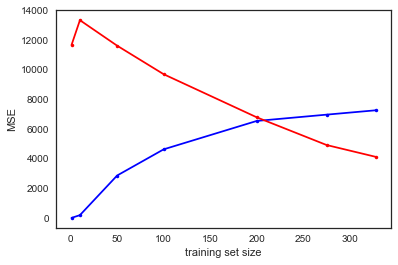

In [798]:
plt.plot(set_sizes, train_mse, '.b-')
plt.xlabel("training set size")
plt.ylabel("MSE")
plt.plot(set_sizes, test_mse, '.r-')

Пробуем различные значения коэффициента l1

In [806]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered_poly, y_filtered, test_size=0.33, random_state=18)
l_options = [1, 10, 25, 50, 100, 150, 200, 250]

train_mse, test_mse = [0] * len(l_options), [0] * len(l_options)

for j in range(len(l_options)):
    l_this = l_options[j]
    print(l_this)    
    model = LassoRegression(n_iter=1000, l1=l_this, intercept=True)
    %time model.fit(X_train, Y_train)
    
    train_mse[j] = sum((X_train.dot(model.theta).values - Y_train.values)**2)
    Y_hypoth = model.predict(X_test)
    test_mse[j] = sum((Y_hypoth.values - Y_test.values)**2)

1
Wall time: 4min 22s
10
iteration 473: precise enough
Wall time: 1min 32s
25
iteration 316: precise enough
Wall time: 1min 1s
50
iteration 409: precise enough
Wall time: 1min 24s
100
iteration 229: precise enough
Wall time: 45.7 s
150
iteration 241: precise enough
Wall time: 46.8 s
200
iteration 111: precise enough
Wall time: 22.7 s
250
iteration 108: precise enough
Wall time: 20.5 s


In [807]:
print(train_mse)
print(test_mse)

[2890.2055002225284, 4285.114838329627, 4829.59635783153, 5627.021170854211, 7264.431878343311, 10150.53632309801, 11789.831732686504, 13169.92199385639]
[1414.8642420721192, 1856.5345497528335, 2240.5755922976196, 2845.044368172322, 4117.845818940322, 6252.483219555849, 7519.262426982587, 8582.059835560238]


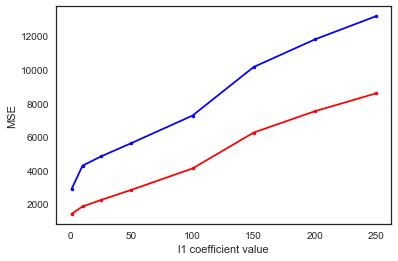

In [808]:
plt.plot(l_options, train_mse, '.b-')
plt.xlabel("l1 coefficient value")
plt.ylabel("MSE")
plt.plot(l_options, test_mse, '.r-')